In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import gc

from argparse import Namespace
from mimetypes import suffix_map
from pathlib import Path
import numpy as np
import yaml
import torch

from pytorch_lightning.trainer import Trainer, seed_everything
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

from kolmopy.dataloaders import TurboFlowDataModule

import matplotlib.pyplot as plt

In [3]:
base_dir = Path('/','home','dicarlo_d','Documents','Code','TurboSuperResultion','recipes','turb_mfn_spec')
data_dir = Path('/','home','dicarlo_d','Documents','Code','TurboSuperResultion','.cache', 'Synth2D_0003.hdf5')
fig_path = base_dir / Path('figures')
res_path = base_dir / Path('results')

In [21]:
seed = 666
seed_everything(seed, workers=True)

# train
batch_size = {
    'train' : 64*64
,   'val'   : 64*64
,   'test'  : 64*64
}
dx = {
    'train' : 2
,   'val'   : 2
,   'test'  : 1
}
dt = {
    'train' : 1
,   'val'   : 1
,   'test'  : 1
}
time_idxs = np.array([21]) #np.array([0, 10, 20, 30])

run = 'moMFN'

model_params = {
    'name' : run
,   'cnn' : False
,   'do_divfree' : False
}

str_time = len(time_idxs) if not time_idxs is None else 'all'
exp_suffix = f'{str_time}x32x32'

n_epoch = 3000
hparams = {
    'name': model_params['name'],
    'do_time' : True,
    'do_cnn' : model_params['cnn'],
    'mlp_layers_num': 4,
    'mlp_layers_dim': 128, 
    'mlp_last_actfn': 'tanh',
    'rff_num_space': 128,
    'rff_scale_space': 10,
    'rff_num_time': 64, 
    'rff_scale_time': 1,
    'do_divfree': model_params['do_divfree'],
    'lam_sdiv': 0, 
    'lam_sfn':  0,    
    'lam_spec': 0,
    'lam_grads':0,    
    'lam_curl' :0,
    'lam_pde' : 0,
    'lam_weight': 1e-5,  # L2 reg on the NN's weights
    'sfn_min_x': 1./256., # maximal resolution
    'sfn_num_centers': 32,
    'sfn_num_increments':8,
    'sfn_patch_dim': 16 # (P/2)
}

Global seed set to 666


(256, 256, 2)
(256, 256, 2)


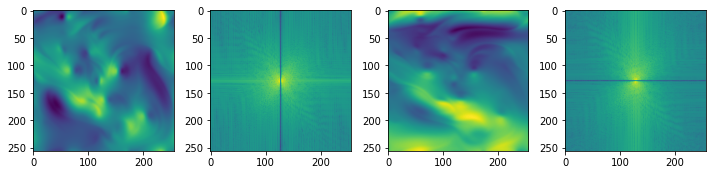

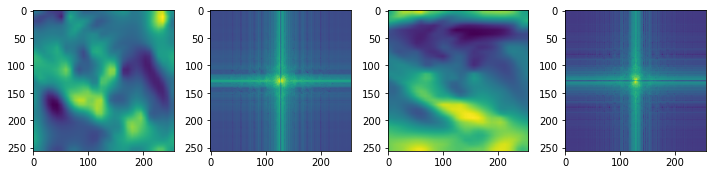

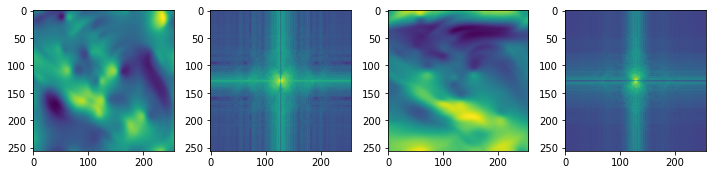

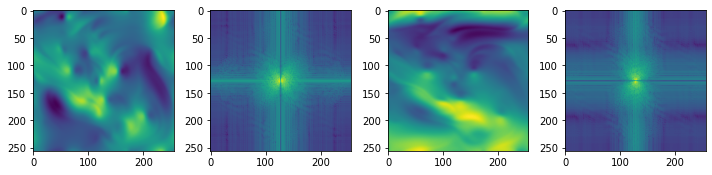

(256, 256, 2)
(256, 256, 2)


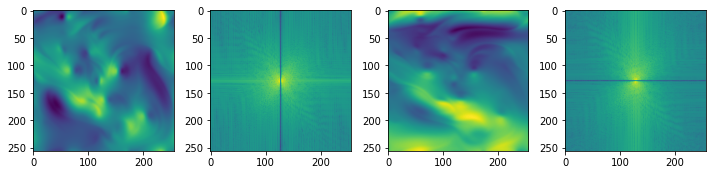

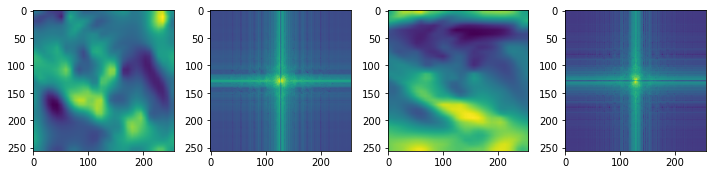

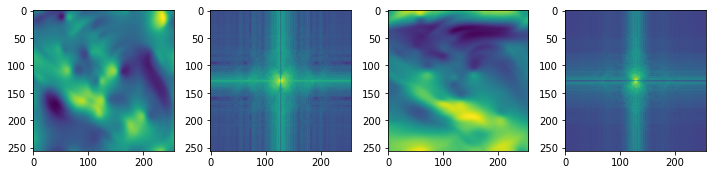

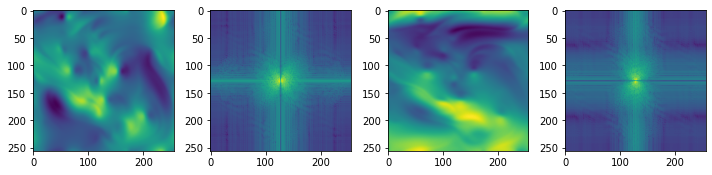

torch.Size([65536, 2]) torch.Size([65536, 2]) (256, 2) (256, 256, 2) (256, 256, 2)
torch.Size([65536, 2]) torch.Size([65536, 2]) (256, 2) (256, 256, 2) (256, 256, 2)


In [22]:
# load dataset for TRAIN
dm_train = TurboFlowDataModule(
    dataset='Synth2D', 
    data_dir=data_dir,
    time_idx=time_idxs,

    train_batch_size=batch_size['train'],
    val_batch_size=batch_size['val'],
    test_batch_size=batch_size['test'],

    train_downsampling_space=dx['train'],
    val_downsampling_space=dx['val'],
    test_downsampling_space=dx['test'],

    train_downsampling_time=dt['train'],
    val_downsampling_time=dt['val'],
    test_downsampling_time=dt['val'],

    train_shuffle=True,
    val_shuffle=False,
    test_shuffle=False,
    num_workers=8)

dm_train.setup(stage='fit')

datasets = [dm_train.train_dataset, dm_train.val_dataset]
for dataset in datasets:
    X, y, extra = dataset[:]
    print(X.shape, y.shape, dataset.img_shape, dataset.vars_shape_img, dataset.fields_shape_img)

In [23]:
early_stop_callback = EarlyStopping(
    monitor='val/loss/tot', 
    patience=30,
    min_delta=1e-5)
checkpoint_callback = ModelCheckpoint(
    monitor="val/loss/tot",
    dirpath=".torch_checkpoints",
    filename="Turb2D-%s-%s-{epoch:02d}-{val_loss:.2f}" % (hparams['name'], exp_suffix),
    save_top_k=1,
    mode="min",
)

trainer = Trainer(
    gpus=1,
    max_epochs=n_epoch, 
    log_every_n_steps=5,
    check_val_every_n_epoch=10, 
    callbacks=[early_stop_callback, checkpoint_callback])

/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory .torch_checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [24]:
from turboflow.models.phyrff import plDivFreeRFFNet

model = plDivFreeRFFNet(**vars(Namespace(**hparams)))
print(model)
# # dset = dm_train.train_dataset[:]

# X, y = dm_train.train_dataset[:]
# model.target_lr_vars = X
# model.target_lr_fields = y
# # model.interp = interpolate.LinearNDInterpolator(X[:,1:], y)
# # print(model)

Res Fourier Filter: Bmin 0 Bwidth 8
- min 0.9899406
- max 7.617011
Res Fourier Filter: Bmin 8 Bwidth 8
- min 8.060235
- max 14.733314
Res Fourier Filter: Bmin 16 Bwidth 16
- min 16.130394
- max 31.472294
Res Fourier Filter: Bmin 32 Bwidth 32
- min 35.19978
- max 60.890526
Res Fourier Filter: Bmin 64 Bwidth 64
- min 65.727066
- max 126.60298
plDivFreeRFFNet(
  (mfn): ResMFN(
    (g0): ResFourierFilter(
      (linear): Linear(in_features=2, out_features=128, bias=True)
    )
    (g1): ResFourierFilter(
      (linear): Linear(in_features=2, out_features=128, bias=True)
    )
    (g2): ResFourierFilter(
      (linear): Linear(in_features=2, out_features=128, bias=True)
    )
    (g3): ResFourierFilter(
      (linear): Linear(in_features=2, out_features=128, bias=True)
    )
    (g4): ResFourierFilter(
      (linear): Linear(in_features=2, out_features=128, bias=True)
    )
    (l1): Linear(in_features=128, out_features=128, bias=True)
    (l2): Linear(in_features=128, out_features=128, bia

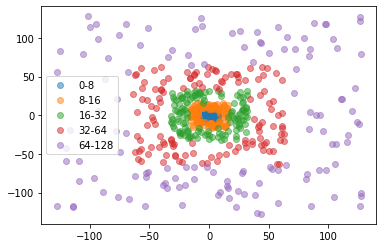

In [25]:
g0 = model.mfn.g0
g1 = model.mfn.g1
g2 = model.mfn.g2
g3 = model.mfn.g3
g4 = model.mfn.g4

for g in [g0, g1, g2, g3, g4]:
    Bm = g.Bmin
    BM = Bm + g.Bwidth
    w = g.linear.weight.data.detach().cpu().numpy()
    plt.scatter(w[:,0], w[:,1], alpha=0.5, label=f'{Bm}-{BM}')

plt.legend()
plt.show()

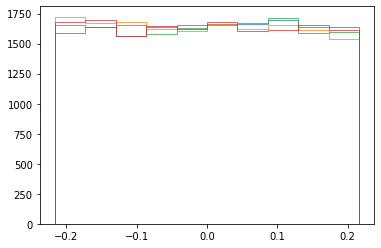

In [26]:
g1 = model.mfn.l1
g2 = model.mfn.l2
g3 = model.mfn.l3
g4 = model.mfn.l4

for g in [g1, g2, g3, g4]:
    w = g.weight.data.detach().cpu().numpy()
    plt.hist(w.flatten(), alpha=0.7, histtype='step')

plt.show()

In [27]:
# for k in range(len(model.mfn.filters)):
#     w0 = model.mfn.filters[k].mu
#     print(w0.shape)
#     plt.figure(figsize=(15,5))
#     for d in range(w0.shape[1]):
#         plt.subplot(1,w0.shape[1],d+1)
#         plt.hist(w0[:,d].detach().cpu().numpy(), bins=100, histtype='step')
#     plt.show()
    
# for k in range(len(model.mfn.filters)):
#     w0 = model.mfn.filters[k].gamma.unsqueeze(-1)
#     plt.figure(figsize=(15,5))
#     for d in range(w0.shape[1]):
#         plt.subplot(1,w0.shape[1],d+1)
#         plt.hist(w0[:,d].detach().cpu().numpy(), bins=100, histtype='step')
#     plt.show()

# for k in range(len(model.mfn.filters)):
#     w0 = model.mfn.filters[k].linear.weight.data
#     print(w0.shape)
#     plt.figure(figsize=(15,5))
#     for d in range(w0.shape[1]):
#         plt.subplot(1,w0.shape[1],d+1)
#         plt.hist(w0[:,d].detach().cpu().numpy(), bins=100, histtype='step')
#     plt.show()

In [28]:
# for k in range(len(model.mfn.filters)):
#     w0 = model.mfn.linear[k].weight.data
#     print(w0.shape)
#     plt.figure(figsize=(15,5))
#     plt.hist(w0.flatten().detach().cpu().numpy(), bins=100, histtype='step')
#     plt.show()

In [29]:
trainer.fit(model, dm_train)
best_model_path = checkpoint_callback.best_model_path
best_model_score = checkpoint_callback.best_model_score

/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params
--------------------------------
0 | mfn  | ResMFN | 69.0 K
--------------------------------
69.0 K    Trainable params
0         Non-trainable params
69.0 K    Total params
0.276     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 666


here 30


Training: -1it [00:00, ?it/s]

here 30
here 30
here 30
here 30
here 30
here 30
here 30
here 30
here 30
here 30


Validating: 0it [00:00, ?it/s]

here 30
here 30
here 30
here 30
here 30
here 30
here 30
here 30
here 30
here 30
here 30


Validating: 0it [00:00, ?it/s]

here 30
here 30
here 30
here 30
here 30
here 30
here 30
here 30
here 30
here 30
here 30


Validating: 0it [00:00, ?it/s]

here 30
here 30
here 30
here 30
here 30
here 30
here 30
here 30
here 30
here 30
here 30


Validating: 0it [00:00, ?it/s]

here 30
here 30
here 30
here 30
here 30
here 30
here 30
here 30
here 30
here 30
here 30


Validating: 0it [00:00, ?it/s]

here 30
here 60
here 60
here 60
here 60
here 60
here 60
here 60
here 60
here 60
here 60


Validating: 0it [00:00, ?it/s]

here 60
here 60
here 60
here 60
here 60
here 60
here 60
here 60
here 60
here 60
here 60


Validating: 0it [00:00, ?it/s]

here 60
here 60
here 60
here 60
here 60
here 60
here 60
here 60
here 60
here 60
here 60


Validating: 0it [00:00, ?it/s]

here 60
here 60
here 60
here 60
here 60
here 60
here 60
here 60
here 60
here 60
here 60


Validating: 0it [00:00, ?it/s]

here 60
here 60
here 60
here 60
here 60
here 60
here 60
here 60
here 60
here 60
here 60


Validating: 0it [00:00, ?it/s]

here 60
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90


Validating: 0it [00:00, ?it/s]

here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90


Validating: 0it [00:00, ?it/s]

here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90


Validating: 0it [00:00, ?it/s]

here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90


Validating: 0it [00:00, ?it/s]

here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90


Validating: 0it [00:00, ?it/s]

here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90


Validating: 0it [00:00, ?it/s]

here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90


Validating: 0it [00:00, ?it/s]

here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90


Validating: 0it [00:00, ?it/s]

here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90


Validating: 0it [00:00, ?it/s]

here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90


Validating: 0it [00:00, ?it/s]

here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90


Validating: 0it [00:00, ?it/s]

here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90


Validating: 0it [00:00, ?it/s]

here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90


Validating: 0it [00:00, ?it/s]

here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90


Validating: 0it [00:00, ?it/s]

here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90


Validating: 0it [00:00, ?it/s]

here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90


Validating: 0it [00:00, ?it/s]

here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90


Validating: 0it [00:00, ?it/s]

here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90


Validating: 0it [00:00, ?it/s]

here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90


Validating: 0it [00:00, ?it/s]

here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90
here 90


Validating: 0it [00:00, ?it/s]

here 90
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120
here 120


Validating: 0it [00:00, ?it/s]

here 120
here 120
here 120
here 120
here 120


/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1046: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
Exception ignored in: <function tqdm.__del__ at 0x7f16f0dace50>
Traceback (most recent call last):
  File "/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/tqdm/std.py", line 1146, in __del__
    def __del__(self):
KeyboardInterrupt: Exception ignored in: 
<function tqdm.__del__ at 0x7f16f0dace50>
Traceback (most recent call last):
  File "/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/tqdm/std.py", line 1146, in __del__
    def __del__(self):
KeyboardInterrupt: 
Exception ignored in: Exception ignored in: <function tqdm.__del__ at 0x7f16f0dace50><function tqdm.__del__ at 0x7f16f0dace50>

Traceback (most recent call last):
Traceback (most r

cpu
cpu


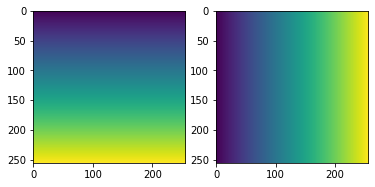

Scale 1/16


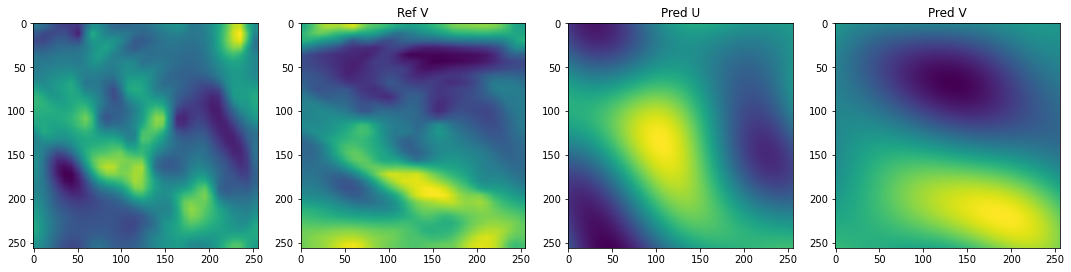

Scale 1/8


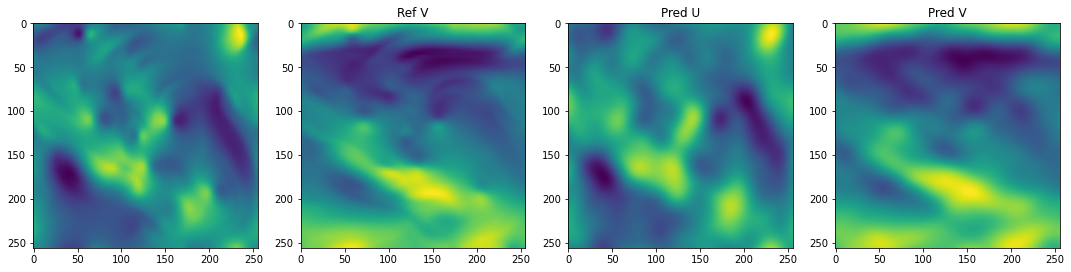

Scale 1/4


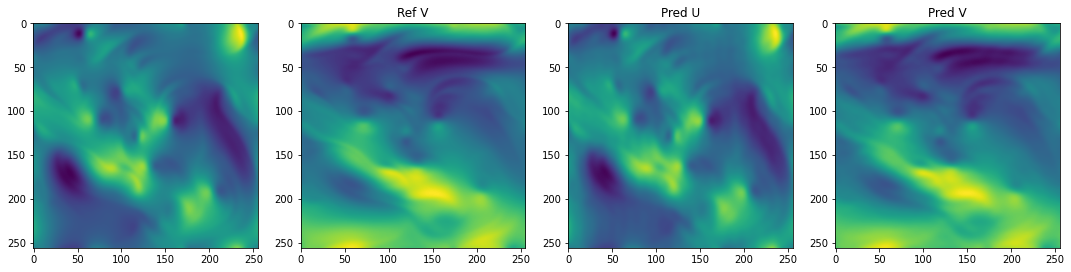

Scale 1/2: Traning


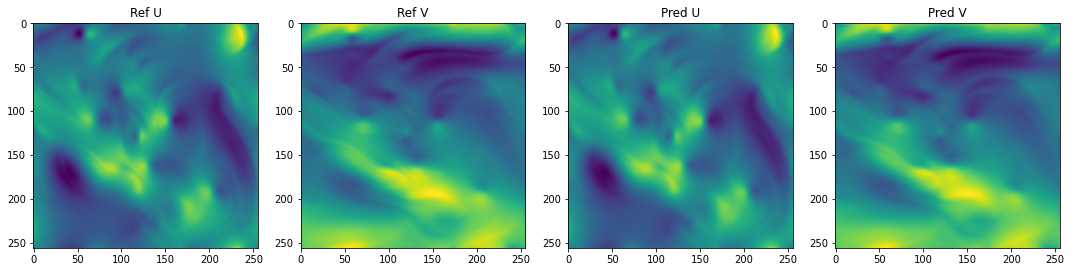

In [41]:
dataset = dm_train.train_dataset

xy, uv, uv_mid = dataset[:]

xy.to(model.device)
print(xy.device)
print(model.device)

uv_pred, uv_pred_mid = model(xy) 

vshape = dataset.vars_shape_img
fshape = dataset.fields_shape_img

x = xy.reshape(*vshape).detach().cpu().numpy()
plt.subplot(121)
plt.imshow(x[:,:,0])
plt.subplot(122)
plt.imshow(x[:,:,1])
plt.show()

scales = ['1/16','1/8','1/4']

for k in range(3):
    u1 = uv_mid[k].reshape(*fshape).detach().cpu().numpy()
    u1_pred = uv_pred_mid[k].reshape(*fshape).detach().cpu().numpy()

    print('Scale ' + scales[k])
    plt.figure(figsize=(15,10))
    plt.title('Ref U')
    plt.subplot(141)
    plt.imshow(u1[:,:,0])
    plt.subplot(142)
    plt.title('Ref V')
    plt.imshow(u1[:,:,1])
    plt.subplot(143)
    plt.title('Pred U')
    plt.imshow(u1_pred[:,:,0])
    plt.subplot(144)
    plt.title('Pred V')
    plt.imshow(u1_pred[:,:,1])
    plt.tight_layout()
    plt.show()
    
    
u = uv.reshape(*fshape).detach().cpu().numpy()
u_pred = uv_pred.reshape(*fshape).detach().cpu().numpy()

print('Scale 1/2: Traning')
plt.figure(figsize=(15,10))
plt.subplot(141)
plt.title('Ref U')
plt.imshow(u[:,:,0])
plt.subplot(142)
plt.title('Ref V')
plt.imshow(u[:,:,1])
plt.subplot(143)
plt.title('Pred U')
plt.imshow(u_pred[:,:,0])
plt.subplot(144)
plt.title('Pred V')
plt.imshow(u_pred[:,:,1])
plt.tight_layout()
plt.show()

#     plt.figure(figsize=(15,10))
#     plt.subplot(231)
#     plt.imshow(y[:,:,0])
#     plt.subplot(232)
#     plt.imshow(y[:,:,1])
#     plt.subplot(233)
#     plt.imshow(y[:,:,2])
#     plt.subplot(234)
#     plt.imshow(p[:,:,0])
#     plt.subplot(235)
#     plt.imshow(p[:,:,1])
#     plt.subplot(236)
#     plt.imshow(w[:,:,0])
#     plt.tight_layout()
#     plt.show()
    
#     plt.subplot(131)
#     plt.plot(y[t,32,:,0])
#     plt.plot(p[t,32,:,0])
#     plt.subplot(132)
#     plt.plot(y[t,32,:,1])
#     plt.plot(p[t,32,:,1])
#     plt.subplot(133)
#     plt.plot(y[t,32,:,2])
#     plt.plot(w[t,32,:,0])
#     plt.show()

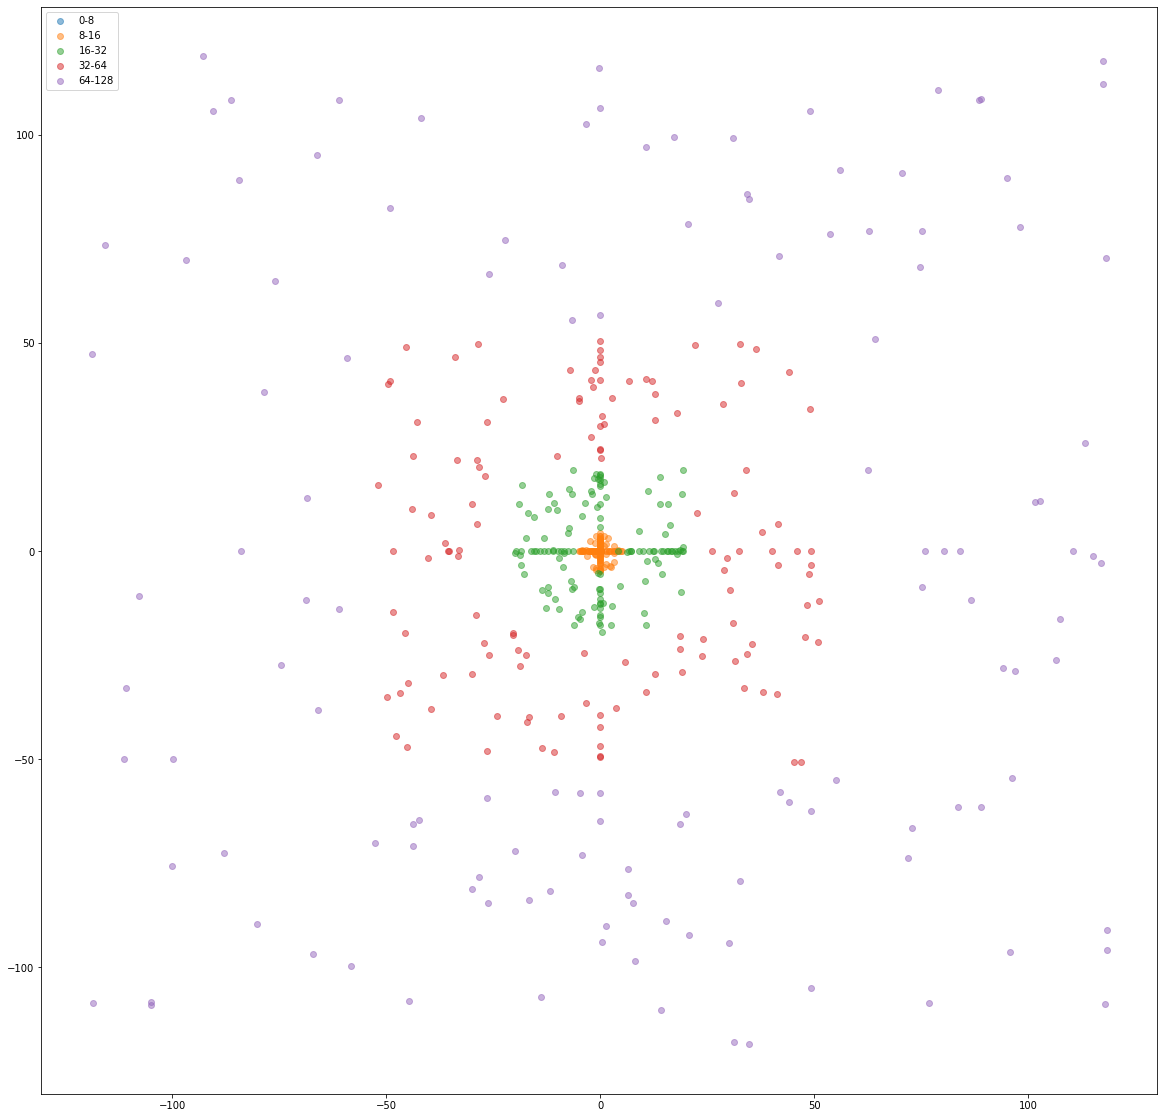

In [42]:
g0 = model.mfn.g0
g1 = model.mfn.g1
g2 = model.mfn.g2
g3 = model.mfn.g3
g4 = model.mfn.g4

plt.figure(figsize=(20,20))
for g in [g0, g1, g2, g3, g4]:
    Bm = g.Bmin
    BM = Bm + g.Bwidth
    w = g.linear.weight.data.detach().cpu().numpy()
    plt.scatter(w[:,0], w[:,1], alpha=0.5, label=f'{Bm}-{BM}')

plt.legend()
plt.show()

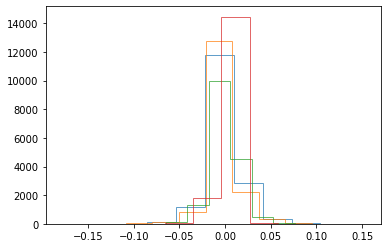

In [43]:
g1 = model.mfn.l1
g2 = model.mfn.l2
g3 = model.mfn.l3
g4 = model.mfn.l4

for g in [g1, g2, g3, g4]:
    w = g.weight.data.detach().cpu().numpy()
    plt.hist(w.flatten(), alpha=0.7, histtype='step')

plt.show()

(256, 256, 2)
(256, 256, 2)


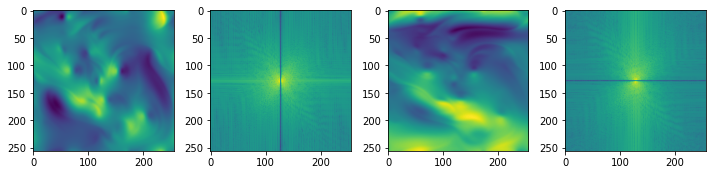

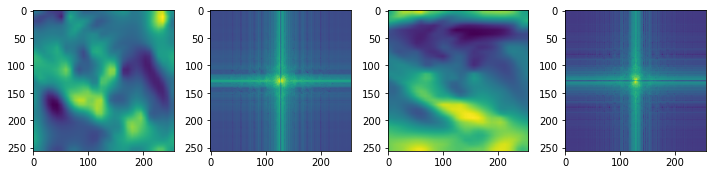

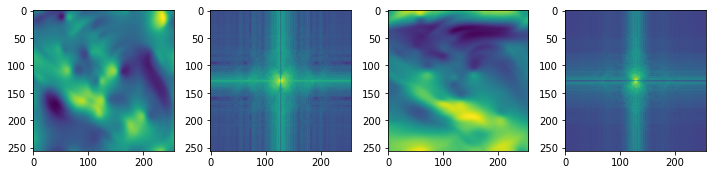

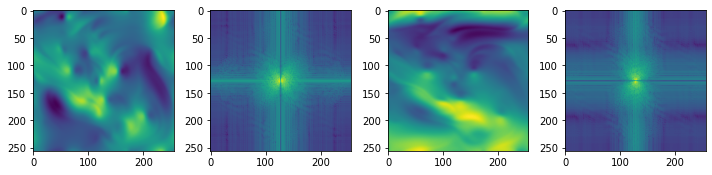

(256, 256, 2)
(256, 256, 2)


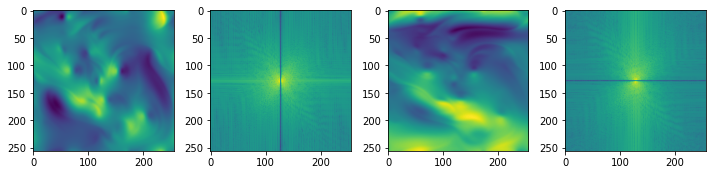

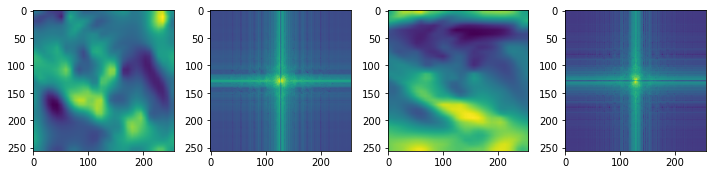

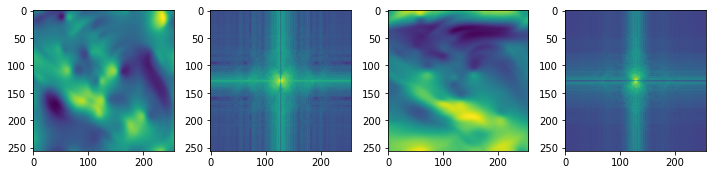

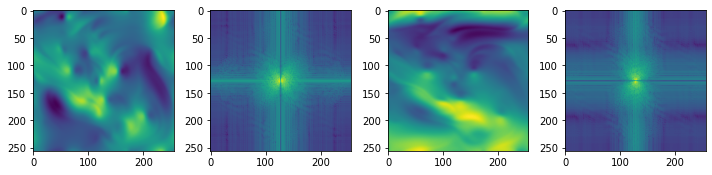

(512, 512, 2)
(512, 512, 2)


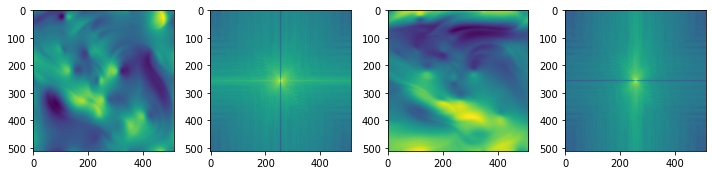

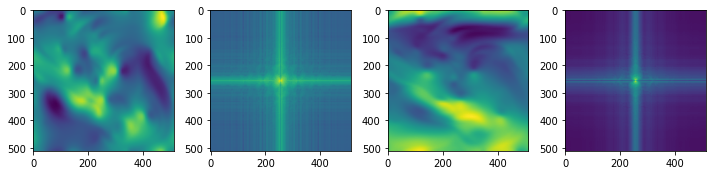

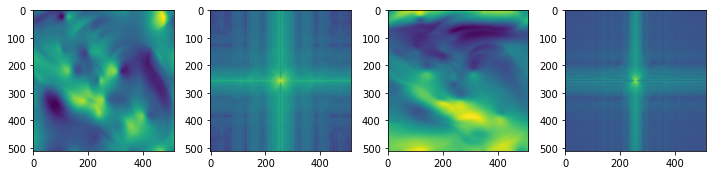

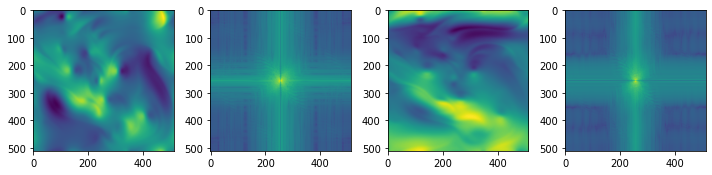

torch.Size([65536, 2]) torch.Size([65536, 2]) (256, 2) (256, 256, 2) (256, 256, 2)
torch.Size([65536, 2]) torch.Size([65536, 2]) (256, 2) (256, 256, 2) (256, 256, 2)
torch.Size([262144, 2]) torch.Size([262144, 2]) (512, 2) (512, 512, 2) (512, 512, 2)


In [32]:
dm_train.setup(stage=None)

datasets = [dm_train.train_dataset, dm_train.val_dataset, dm_train.test_dataset]
for dataset in datasets:
    X, y, extra = dataset[:]
    print(X.shape, y.shape, dataset.img_shape, dataset.vars_shape_img, dataset.fields_shape_img)

cpu
cpu


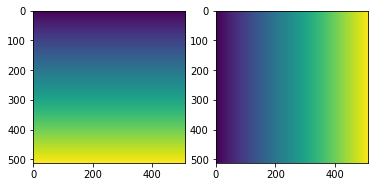

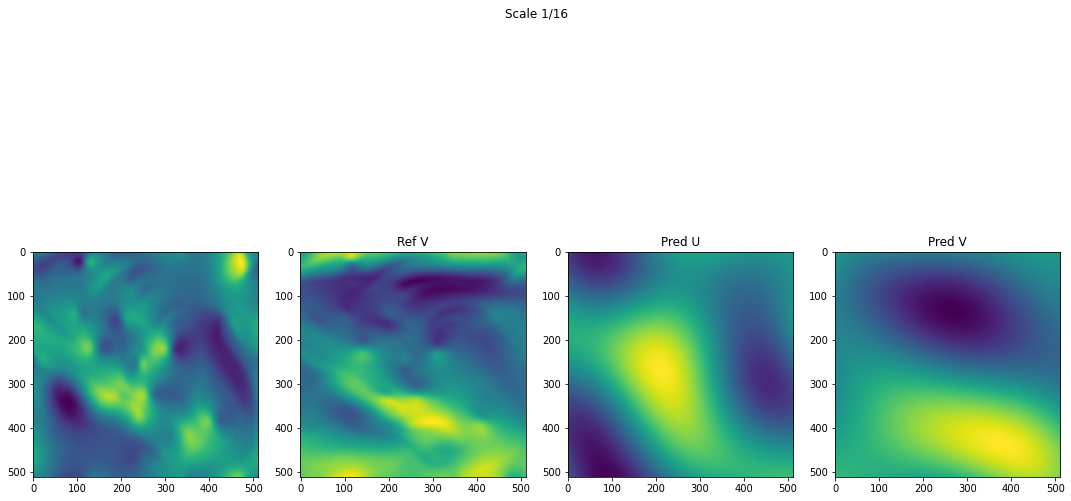

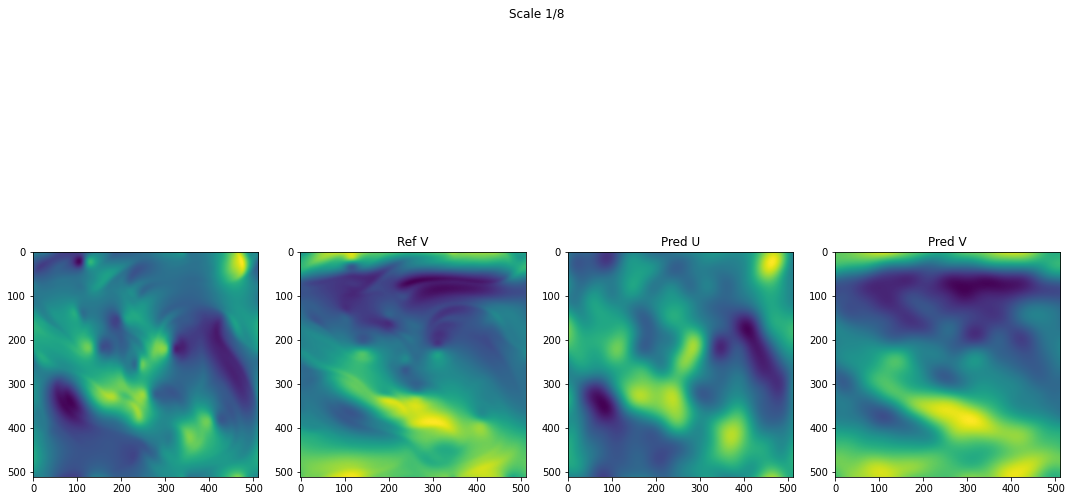

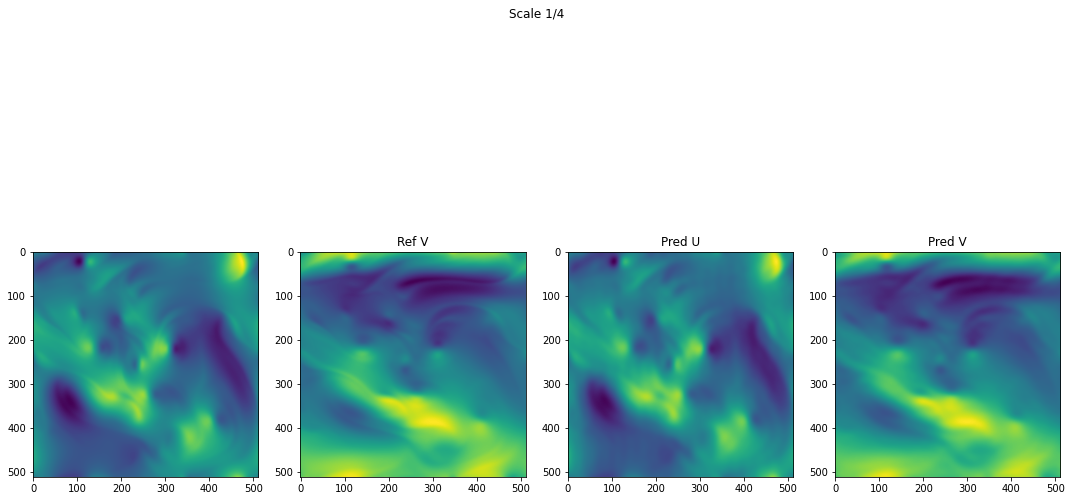

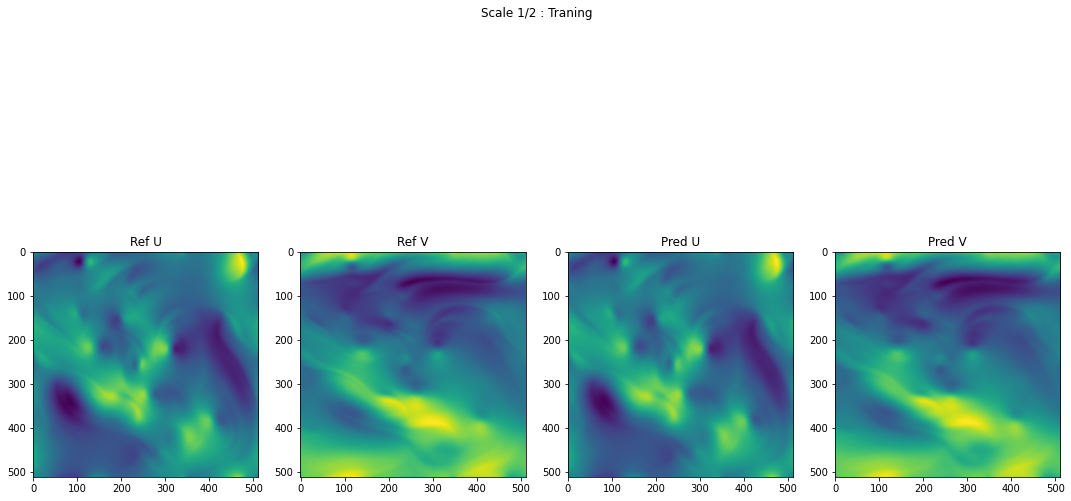

In [38]:
dataset = dm_train.test_dataset

xy, uv, uv_mid = dataset[:]

xy.to(model.device)
print(xy.device)
print(model.device)

uv_pred, uv_pred_mid = model(xy) 

vshape = dataset.vars_shape_img
fshape = dataset.fields_shape_img

x = xy.reshape(*vshape).detach().cpu().numpy()
plt.subplot(121)
plt.imshow(x[:,:,0])
plt.subplot(122)
plt.imshow(x[:,:,1])
plt.show()

scales = ['1/16','1/8','1/4']

for k in range(3):
    u1 = uv_mid[k].reshape(*fshape).detach().cpu().numpy()
    u1_pred = uv_pred_mid[k].reshape(*fshape).detach().cpu().numpy()

    plt.figure(figsize=(15,10))
    plt.suptitle('Scale ' + scales[k])
    plt.title('Ref U')
    plt.subplot(141)
    plt.imshow(u1[:,:,0])
    plt.subplot(142)
    plt.title('Ref V')
    plt.imshow(u1[:,:,1])
    plt.subplot(143)
    plt.title('Pred U')
    plt.imshow(u1_pred[:,:,0])
    plt.subplot(144)
    plt.title('Pred V')
    plt.imshow(u1_pred[:,:,1])
    plt.tight_layout()
    plt.show()
    
    
u = uv.reshape(*fshape).detach().cpu().numpy()
u_pred = uv_pred.reshape(*fshape).detach().cpu().numpy()

plt.figure(figsize=(15,10))
plt.suptitle('Scale 1/2 : Traning')
plt.subplot(141)
plt.title('Ref U')
plt.imshow(u[:,:,0])
plt.subplot(142)
plt.title('Ref V')
plt.imshow(u[:,:,1])
plt.subplot(143)
plt.title('Pred U')
plt.imshow(u_pred[:,:,0])
plt.subplot(144)
plt.title('Pred V')
plt.imshow(u_pred[:,:,1])
plt.tight_layout()
plt.show()

#     plt.figure(figsize=(15,10))
#     plt.subplot(231)
#     plt.imshow(y[:,:,0])
#     plt.subplot(232)
#     plt.imshow(y[:,:,1])
#     plt.subplot(233)
#     plt.imshow(y[:,:,2])
#     plt.subplot(234)
#     plt.imshow(p[:,:,0])
#     plt.subplot(235)
#     plt.imshow(p[:,:,1])
#     plt.subplot(236)
#     plt.imshow(w[:,:,0])
#     plt.tight_layout()
#     plt.show()
    
#     plt.subplot(131)
#     plt.plot(y[t,32,:,0])
#     plt.plot(p[t,32,:,0])
#     plt.subplot(132)
#     plt.plot(y[t,32,:,1])
#     plt.plot(p[t,32,:,1])
#     plt.subplot(133)
#     plt.plot(y[t,32,:,2])
#     plt.plot(w[t,32,:,0])
#     plt.show()

In [ ]:
dataset = dm_train.train_dataset

xy, uv, extra = dataset[:]
uv_pred, extra = model(xy)

vshape = dataset.vars_shape_img
fshape = dataset.fields_shape_img
x = xy.reshape(*vshape).detach().cpu().numpy()
y = uv.reshape(*fshape).detach().cpu().numpy()
p = uv_pred.reshape(*fshape[:3]).detach().cpu().numpy()
# w = w_pred.reshape(*fshape[:3],).detach().cpu().numpy()

for t in range(fshape[0]):
    plt.figure(figsize=(15,10))
    plt.subplot(231)
    plt.imshow(y[:,:,0])
    plt.subplot(232)
    plt.imshow(y[:,:,1])
    plt.subplot(233)
    plt.imshow(y[:,:,2])
    plt.subplot(234)
    plt.imshow(p[:,:,0])
    plt.subplot(235)
    plt.imshow(p[:,:,1])
    plt.subplot(236)
    plt.imshow(w[:,:,0])
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.plot(y[t,32,:,0])
    plt.plot(p[t,32,:,0])
    plt.subplot(132)
    plt.plot(y[t,32,:,1])
    plt.plot(p[t,32,:,1])
    plt.subplot(133)
    plt.plot(y[t,32,:,2])
    plt.plot(w[t,32,:,0])
    plt.show()

In [ ]:
dataset = dm_train.val_dataset

xy, uv = dataset[:]
uv_pred, w_pred, _ = model(xy)

vshape = dataset.vars_shape_img
fshape = dataset.fields_shape_img
x = xy.reshape(*vshape).detach().cpu().numpy()
y = uv.reshape(*fshape).detach().cpu().numpy()
p = uv_pred.reshape(*fshape[:3],2).detach().cpu().numpy()
w = w_pred.reshape(*fshape[:3],1).detach().cpu().numpy()

for t in range(fshape[0]):
    plt.figure(figsize=(15,10))
    plt.subplot(231)
    plt.imshow(y[t,:,:,0])
    plt.subplot(232)
    plt.imshow(y[t,:,:,1])
    plt.subplot(233)
    plt.imshow(y[t,:,:,2])
    plt.subplot(234)
    plt.imshow(p[t,:,:,0])
    plt.subplot(235)
    plt.imshow(p[t,:,:,1])
    plt.subplot(236)
    plt.imshow(w[t,:,:,0])
    plt.tight_layout()
    plt.show()
    plt.plot(y[t,32,:,0])
    plt.plot(p[t,32,:,0])
    plt.show()

In [ ]:
dataset = dm_train.test_dataset

xy, uv = dataset[:]
uv_pred = model.mfn(xy)[0]

vshape = dataset.vars_shape_img
fshape = dataset.fields_shape_img
x = xy.reshape(*vshape).detach().cpu().numpy()
y = uv.reshape(*fshape).detach().cpu().numpy()
p = uv_pred.reshape(*fshape[:3],2).detach().cpu().numpy()

for t in range(fshape[0]):
    plt.figure(figsize=(15,10))
    plt.subplot(231)
    plt.imshow(y[t,:,:,0])
    plt.subplot(232)
    plt.imshow(y[t,:,:,1])
    plt.subplot(233)
    plt.imshow(y[t,:,:,2])
    plt.subplot(234)
    plt.imshow(p[t,:,:,0])
    plt.subplot(235)
    plt.imshow(p[t,:,:,1])
    plt.subplot(236)
    plt.imshow(w[t,:,:,0])
    plt.tight_layout()
    plt.show()
    plt.plot(y[t,32,:,0])
    plt.plot(p[t,32,:,0])
    plt.show()

In [ ]:
dataset = dm_train.val_dataset
xy, uv = dataset[:]
fshape = dataset.fields_shape_img
vshape = dataset.vars_shape_img

xy.requires_grad_(True)
uv_pred = model.mfn(xy)[0]

from turboflow.utils import torch_utils as tch

u, v = torch.split(uv_pred, 1, -1)
print(u.shape)

du = tch.diff(u, xy)
u_t, u_x, u_y = du.split(1, -1)

dv = tch.diff(v, xy)
v_t, v_x, v_y = dv.split(1, -1)

plt.imshow(u.detach().numpy().reshape(*fshape[:3])[0,:,:])
plt.show()
plt.imshow(u_x.detach().numpy().reshape(*fshape[:3])[0,:,:])
plt.show()

u_x_diff = np.diff(u.detach().numpy().reshape(*fshape[:3])[0,32,:])

plt.plot(u.detach().numpy().reshape(*fshape[:3])[0,32,:])
plt.plot(u_x.detach().numpy().reshape(*fshape[:3])[0,32,:])
plt.plot(u_x_diff)
plt.show()

In [ ]:
print(vshape)
print(fshape)
w = v_x - u_y

plt.imshow(w.detach().numpy().reshape(*fshape[:3])[1,:,:])

In [ ]:
dw = tch.diff(w, xy)
w_t, w_x, w_y = dw.split(1, -1)
ddw = tch.diff(dw, xy)
w_tt, w_xx, w_yy = ddw.split(1, -1)

# spatial change of vorticity / unit volume (u dot Nabla)w
w_spatial = u*w_x + v*w_y
# diffusion of vorticity / univ volume (nu Laplacian w)
diffusion = 0 # 1/self.Re
w_diffusion = diffusion*(w_xx + w_yy)

In [ ]:
plt.imshow(w_spatial.detach().numpy().reshape(*fshape[:3])[1,:,:])

In [ ]:
plt.imshow(w_t.detach().numpy().reshape(*fshape[:3])[1,:,:])

In [ ]:
plt.imshow(torch.abs(w_t + w_spatial).detach().numpy().reshape(*fshape[:3])[1,:,:])
plt.colorbar()

In [ ]:
from turboflow.utils import phy_utils as phy

In [ ]:
t = 0

UV = uv.detach().numpy().reshape(*fshape)
XY = xy.detach().numpy().reshape(*vshape)
print(UV.shape)
print(XY.shape)

plt.figure(figsize=(15,4))
plt.subplot(151)
plt.imshow(XY[t,:,:,0])
plt.subplot(152)
plt.imshow(XY[t,:,:,1])
plt.subplot(153)
plt.imshow(XY[t,:,:,2])
plt.subplot(154)
plt.imshow(UV[t,:,:,0])
plt.subplot(155)
plt.imshow(UV[t,:,:,1])
plt.tight_layout()
plt.show()

[[Udx, Udy], [Vdx, Vdy]] = phy.my_grad([UV[t,:,:,0], UV[t,:,:,1]], [XY[t,:,0,1], XY[t,0,:,2]])

plt.figure(figsize=(12,5))
plt.subplot(141)
plt.imshow(Udx)
plt.subplot(142)
plt.imshow(Udy)
plt.subplot(143)
plt.imshow(Vdx)
plt.subplot(144)
plt.imshow(Vdy)
plt.tight_layout()
plt.show()

W = Vdx - Udy

plt.figure(figsize=(5,5))
plt.imshow(W)
plt.show()

In [ ]:
t=0
[[Udx, Udy], [Vdx, Vdy]] = phy.my_grad([UV[t,:,:,0], UV[t,:,:,1]], [XY[t,:,0,1], XY[t,0,:,2]])
W0 = Vdx - Udy
t=1
[[Udx, Udy], [Vdx, Vdy]] = phy.my_grad([UV[t,:,:,0], UV[t,:,:,1]], [XY[t,:,0,1], XY[t,0,:,2]])
W1 = Vdx - Udy
t=2
[[Udx, Udy], [Vdx, Vdy]] = phy.my_grad([UV[t,:,:,0], UV[t,:,:,1]], [XY[t,:,0,1], XY[t,0,:,2]])
W2 = Vdx - Udy

Wdt = (W1-W0)/4 + (W2-W1)/4
plt.imshow(Wdt)
plt.colorbar()
plt.show()

In [ ]:
t=1
[[Udx, Udy], [Vdx, Vdy]] = phy.my_grad([UV[t,:,:,0], UV[t,:,:,1]], [XY[t,:,0,1], XY[t,0,:,2]])
W1 = Vdx - Udy

[[Wdx, Wdy]] = phy.my_grad([W1], [XY[t,:,0,1], XY[t,0,:,2]])
Wspat = UV[t,:,:,0]*Wdx + UV[t,:,:,1]*Wdy
plt.imshow(Wspat)
plt.colorbar()
plt.show()

In [ ]:
plt.imshow(Wdt/np.linalg.norm(Wdt) + Wspat/np.linalg.norm(Wspat))
plt.colorbar()